In [6]:
import numpy as np
from pandas import DataFrame

import pickle
from seaborn import pairplot, displot

import sklearn
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import PredictionErrorDisplay, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

import torch
from torch import nn, optim, cuda

In [8]:
print(f'Torch version = {torch.__version__}')
print(f'Skorch version = {skorch.__version__}')
print(f'Sklearn version = {sklearn.__version__}')

Torch version = 2.0.0+cpu
Skorch version = 0.14.0
Sklearn version = 1.2.2


In [24]:
SEED = 42
cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)

In [25]:
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

AssertionError: 

In [26]:
X, y = make_regression(n_samples=200,
                       n_features=2,
                       n_targets=1,
                       random_state=SEED)
X = X.astype(np.float32)
y =y.reshape(-1, 1).astype(np.float32)
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (200, 2)
y.shape = (200, 1)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (160, 2)
y_train.shape = (160, 1)
X_test.shape = (40, 2)
y_test.shape = (40, 1)


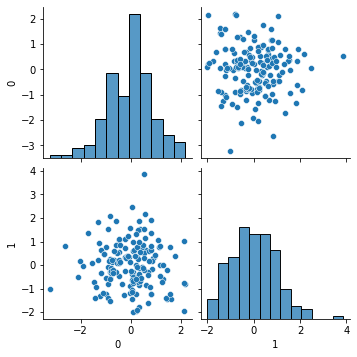

In [28]:
df = DataFrame(X_train)
pairplot(df);

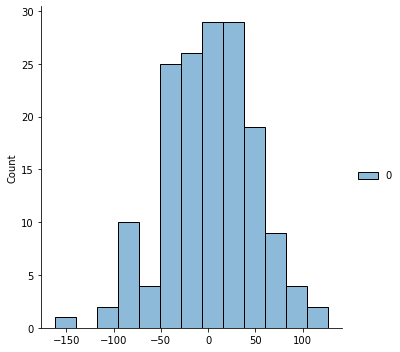

In [29]:
displot(y_train);

In [30]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [46]:
def print_performance(title, model, is_already_fit=False, y_train=y_train, y_scaler=None):
    if not is_already_fit :
        if y_scaler is not None:
            y_train = y_scaler.fit_transform(y_train)
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    if y_scaler is not None:
        perdictions = y_scaler.inverse_transform(predictions)
    performance = mean_absolute_error(y_test, predictions)
    print(f'{title} : {performance}')
    
print_performance('DummyRegressor with mean', DummyRegressor())
print_performance('DummyRegressor with median', DummyRegressor(strategy='median'))
print_performance('DummyRegressor with 75th quantile', DummyRegressor(strategy='quantile', quantile=.75))

DummyRegressor with mean : 42.69603729248047
DummyRegressor with median : 42.696044921875
DummyRegressor with 75th quantile : 42.7015288002789


In [47]:
#Skorch
callbacks = [EarlyStopping(threshold_mode='abs', load_best=True)]

module = nn.Sequential(nn.Linear(2, 8),
                       nn.ReLU(),
                       nn.Linear(8, 1))

# Module can be either a class or an instrance
network = NeuralNetRegressor(module=module,
                             optimizer=optim.Adam,
                             max_epochs=200,
                             device=DEVICE,
                             batch_size=32,
                             criterion=nn.L1Loss(),
                             callbacks=callbacks)

pipeline = Pipeline((
    ('X_scaler', MinMaxScaler()),
    ('neural_network', network)
)).fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2973        0.2500  0.0070
      2        0.1900        0.1485  0.0100
      3        0.1513        0.1186  0.0090
      4        0.1526        0.1186  0.0040
      5        0.1479        0.1100  0.0040
      6        0.1343        0.1105  0.0040
      7        0.1294        0.1203  0.0030
      8        0.1302        0.1233  0.0040
      9        0.1272        0.1114  0.0040
     10        0.1223        0.1018  0.0030
     11        0.1191        0.0960  0.0030
     12        0.1138        0.0966  0.0020
     13        0.1091        0.0957  0.0030
     14        0.1041        0.0877  0.0030
     15        0.0975        0.0777  0.0040
     16        0.0898        0.0706  0.0030
     17        0.0808        0.0653  0.0030
     18        0.0706        0.0556  0.0030
     19        0.0597        0.0454  0.0030
     20        0.0478        0.0337  0.0030
     21        0.0346        0.0

In [48]:
print(pipeline)

Pipeline(steps=[('X_scaler', MinMaxScaler()),
                ('neural_network',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  ),
))])


In [49]:
# save pipeline
with open('model.pkl', 'wb') as f:
    pickle.dump([pipeline, y_scaler], f)
    
def test_saved_pipeline() :
    with open('model.pkl', 'rb') as f:
        saved_pipeline, saved_y_scaler = pickle.load(f)
    # X_scaler configuration
    saved_X_scaler = saved_pipeline.get_params()['steps'][0][1]
    assert isinstance(saved_X_scaler, MinMaxScaler)
    pipeline_X_scaler = pipeline.get_params()['steps'][0][1]
    assert np.array_equal(saved_X_scaler.data_min_, pipeline_X_scaler.data_min_)
    assert np.array_equal(saved_X_scaler.data_max_, pipeline_X_scaler.data_max_)
    # y_scaler configuration
    assert isinstance(saved_y_scaler, MinMaxScaler)
    assert np.array_equal(saved_y_scaler.data_min_, y_scaler.data_min_)
    assert np.array_equal(saved_y_scaler.data_max_, y_scaler.data_max_)
    # neural network
    saved_nn = saved_pipeline.get_params('steps')['neural_network'].module_
    pipeline_nn = pipeline.get_params('steps')['neural_network'].module_
    assert isinstance(saved_nn, nn.Sequential)
    assert len(saved_nn)== len(pipeline_nn)
    for pipeline_layer, underlying_layer in zip(pipeline_nn, saved_nn):
        for name, value in pipeline_layer.state_dict().items():
            assert torch.equal(value, underlying_layer.state_dict()[name])
            
test_saved_pipeline()

In [50]:
# making a single prediction
data = X[0].reshape(1, -1)
prediction = y_scaler.inverse_transform(pipeline.predict(data))
print(f'Data = {data[0]} : prediction = {prediction[0, 0] : .4f} and actual = {y[0, 0] : .4f}')

Data = [0.51504767 3.8527315 ] : prediction =  112.0504 and actual =  126.7016


In [51]:
# evaluation on test set
print_performance('Custom skorch model', pipeline, is_already_fit=True, y_scaler=y_scaler)

Custom skorch model : 42.546051025390625


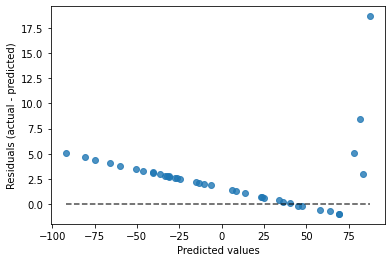

In [53]:
PredictionErrorDisplay.from_predictions(y_test, y_scaler.inverse_transform(pipeline.predict(X_test)));

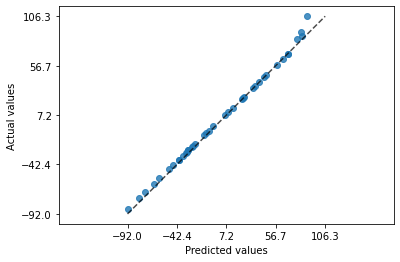

In [55]:
PredictionErrorDisplay.from_predictions(y_test, y_scaler.inverse_transform(pipeline.predict(X_test)),
                                        kind='actual_vs_predicted');